# Title : Predict the amount of taxi orders for the next hour

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
#Download all the important libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [2]:
#Load the data
df =pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col=[0])
display(df)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
df.sort_index(inplace=True)

In [4]:
#Resample data by 1 hour
df=df.resample('1H').sum()

In [5]:
#Check the missing values
df.isnull().sum()

num_orders    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


In [7]:
# ADF Test for stationary
result = adfuller(df['num_orders'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -3.068924289027954
p-value: 0.028940051402613028


Since p = 0.029 < 0.05, we can conclude that the series is likely stationary, and  not need differencing (d = 0) for ARIMA.

## Analysis

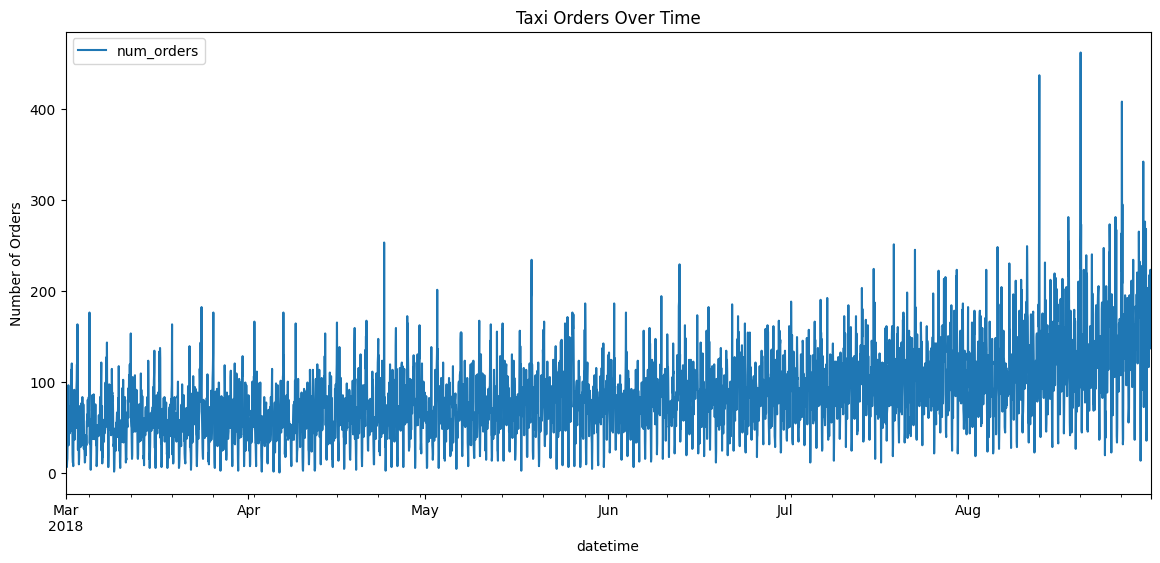

In [8]:
# Plot the data
df.plot(figsize=(14, 6), title='Taxi Orders Over Time')
plt.ylabel('Number of Orders')
plt.show()

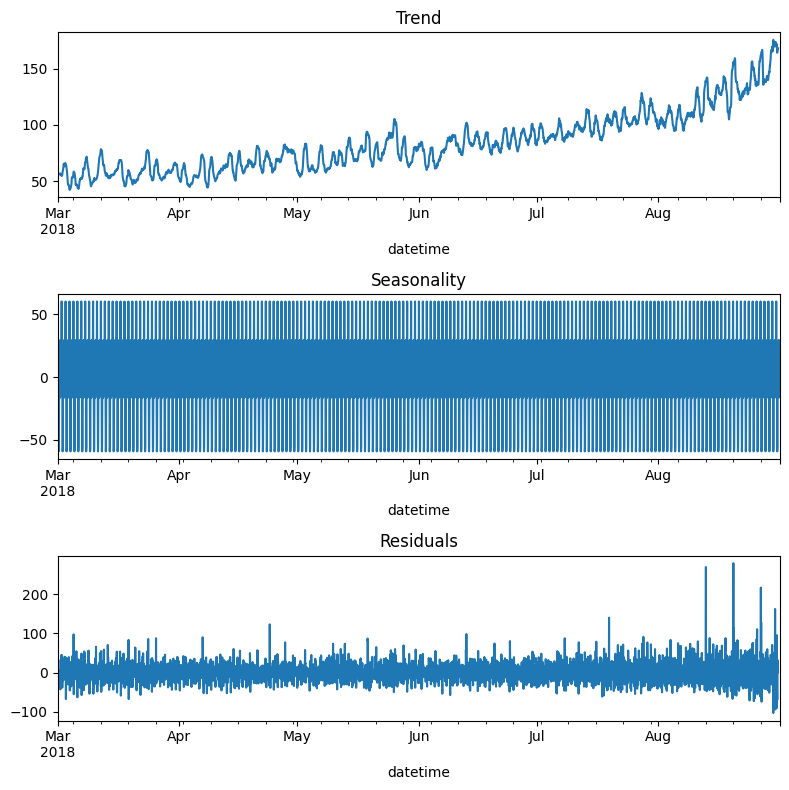

In [9]:
#Trends and Seasonality
decomposed = seasonal_decompose(df)

plt.figure(figsize=(8, 8))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()  

There is an overall increasing trend in the number of orders over time. This indicates that the demand is growing steadily. The seasonal component shows recurring patterns. The residuals appear to have more variability over time, increasing as the trend grows.


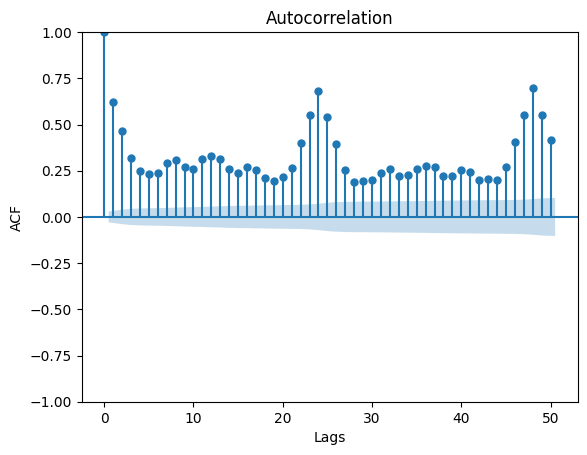

In [10]:
#Plot ACF
acf= plot_acf(df['num_orders'], lags=50)
plt.xlabel("Lags")
plt.ylabel("ACF")
plt.show()

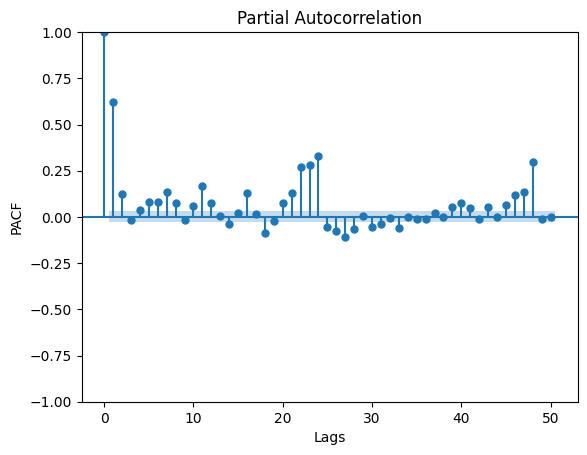

In [11]:
#Plot PACF
pacf=plot_pacf(df['num_orders'], lags=50)
plt.xlabel("Lags")
plt.ylabel("PACF")
plt.show()

ACF measures the overall correlation between a time series and its lagged values, while PACF measures the direct correlation, excluding the influence of intermediate lags.

## Training

In [12]:
def make_features(df, rolling_mean_size):
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek

    for lag in range(1, 25):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = (
        df['num_orders'].shift().rolling(rolling_mean_size).mean()
    )
make_features(df, 10)

In [13]:
#Split training and testing set
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [14]:
#Features and targets
features_train =train.drop(['num_orders'], axis=1)
target_train =train['num_orders']
features_test =test.drop(['num_orders'], axis=1)
target_test =test['num_orders']

In [15]:
print(f'The training set shape is {features_train.shape} for features and {target_train.shape} for targets')
print(f'The test set shape is {features_test.shape} for features and {target_test.shape} for targets')

The training set shape is (3950, 27) for features and (3950,) for targets
The test set shape is (442, 27) for features and (442,) for targets


In [16]:
#Linear Regression Model
lr_model = LinearRegression()
lr_model.fit(features_train, target_train)
pred_lr = lr_model.predict(features_test)

In [17]:
# Random Forest Model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(features_train, target_train)
pred_rf = rf_model.predict(features_test)

In [18]:
#GradientBoost Model
# Define parameter grid
gbr_params = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 1.0]
}

gbr = GradientBoostingRegressor(random_state=42)
gbr_search = RandomizedSearchCV(gbr, gbr_params, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1)
gbr_search.fit(features_train, target_train)

gbr_best = gbr_search.best_estimator_
pred_gbr = gbr_best.predict(features_test)

In [19]:
#XGB model
xgb_params = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
xgb_search = RandomizedSearchCV(xgb, xgb_params, n_iter=10, cv=3, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1)
xgb_search.fit(features_train, target_train)

xgb_best = xgb_search.best_estimator_
xgb_preds = xgb_best.predict(features_test)

In [20]:
#Catboost model
catboost_params = {
    'iterations': [200, 300],
    'learning_rate': [0.03, 0.1],
    'depth': [4, 6, 8]
}

catboost = CatBoostRegressor(verbose=0, random_state=42)
catboost_search = RandomizedSearchCV(catboost, catboost_params, n_iter=6, cv=3, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1)
catboost_search.fit(features_train, target_train)

catboost_best = catboost_search.best_estimator_
catboost_preds = catboost_best.predict(features_test)


In [21]:
#SARIMAX model
model = SARIMAX(df['num_orders'], 
                order=(2,1,2), 
                seasonal_order=(1,1,1,24), 
                enforce_stationarity=False, 
                enforce_invertibility=False)

sa_model = model.fit(disp=False)
# make predictions
start_value =len(train)
end_value = len(train) + len(test) -1
ma_pred = sa_model.predict(start=start_value, end=end_value, dynamic=False)


/opt/conda/envs/python3/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Train the data using different models like RandomForestRegressor,  Random Forest, GradientBoost, XGB model, CatBoost, SARIMAX etc.

## Testing

In [22]:
#Linear Regression Model
rmse_lr = np.sqrt(mean_squared_error(target_test, pred_lr))
print(f'Linear Regression RMSE: {rmse_lr:.2f}')

Linear Regression RMSE: 44.98


In [23]:
# Random Forest Model
rmse_rf = np.sqrt(mean_squared_error(target_test, pred_rf))
print(f'Random Forest RMSE: {rmse_rf:.2f}')

Random Forest RMSE: 42.59


In [24]:
#GradientBoost Model
rmse_gbr = np.sqrt(mean_squared_error(target_test, pred_gbr))
print(f'GradientBoosting RMSE: {rmse_gbr:.2f}')

GradientBoosting RMSE: 43.09


In [25]:
#XGB model
xgb_rmse = np.sqrt(mean_squared_error(target_test, xgb_preds))
print(f'XGBoost RMSE: {xgb_rmse:.2f}')

XGBoost RMSE: 45.36


In [26]:
#Catboost model
catboost_rmse =np.sqrt(mean_squared_error(target_test, catboost_preds))
print(f'CatBoost RMSE: {catboost_rmse:.2f}')

CatBoost RMSE: 42.09


In [27]:
#SARIMAX model
rmse_sarimax = np.sqrt(mean_squared_error(target_test, ma_pred))
print(f'SARIMAX model RMSE: {rmse_sarimax:.2f}')

SARIMAX model RMSE: 40.69


From the above different model RMSE of the SARIMAX model is 40.69 which is less compared to other different models. 

# Conclusion

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.
In the first stage, import the libraries and load the data. Check the missing values and dtypes. Resample the data by 1 hour. Using  In the first stage, import the libraries and load the data. Check the missing values and dtypes. Resample the data by 1 hour. Using  In the first stage, import the libraries and load the data. Check the missing values and dtypes. Resample the data by 1 hour. Using ADF Test to check the series is  stationary or not. Plot the data and plot acf, pacf, seasonal changes etc.

Train the data using different models like RandomForestRegressor,  Random Forest, GradientBoost, XGB model, CatBoost, SARIMAX and test the results. The RMSE value obtained for different models are:
- Linear Regression RMSE: 44.98
- Random Forest RMSE: 42.59
- GradientBoosting RMSE: 43.09
- XGBoost RMSE: 45.36
- CatBoost RMSE: 42.09
- SARIMAX model RMSE: 40.69

A lower RMSE indicates a better model fit, as it means the predictions are closer to the actual observations. So from the above models, SARIMAX model has lower RMSE implies the predictions are closer to the actual observations.